In [69]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)



parula = np.load('/Users/arcticfox/parula_colors.npy')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times, times2)-times[0], 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

In [26]:
tpeak = 12455.942687932402
distance = 9.8 * units.pc
oot = (fwc.orbit == 2) & (fwc.time.value<tpeak-200)
it = np.where((fwc.orbit==2) & (fwc.time.value > tpeak-100))[0]
template = np.nanmean(fwc.flux[oot,:], axis=0)
max_template = np.nanmax(fwc.flux[it,:], axis=0)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


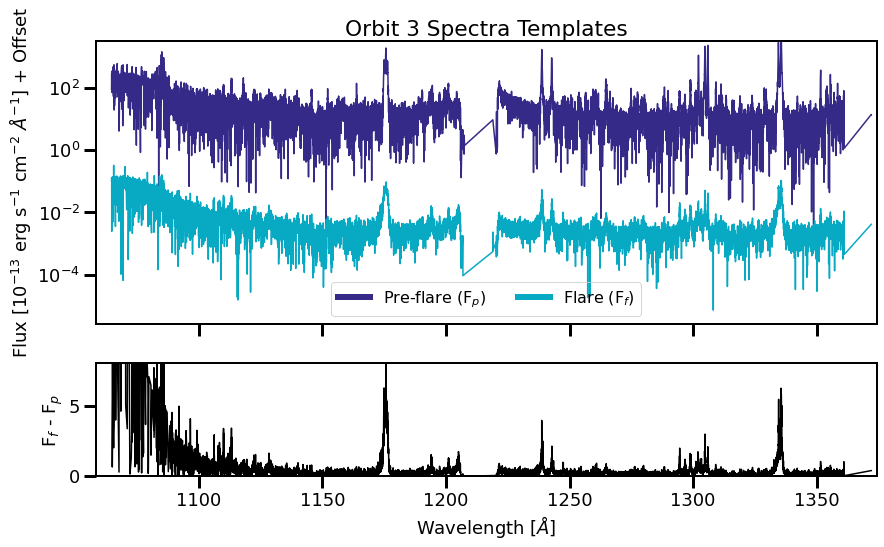

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(14,8), 
                               gridspec_kw={'height_ratios':[2.5,1]},
                               sharex=True)
scaling = 10**-13
fig.set_facecolor('w')
ax1.plot(fwc.wavelength[0][template>0], 
         template[template>0]/scaling*1000, color=parula[0])
ax1.plot(fwc.wavelength[0][max_template>0], 
         max_template[max_template>0]/scaling/100, color=parula[100])
ax1.set_title('Orbit 3 Spectra Templates')
ax1.plot(np.ones(10), np.ones(10), c=parula[0], label='Pre-flare (F$_{p}$)', lw=6)
ax1.plot(np.ones(10), np.ones(10), c=parula[100], label='Flare (F$_{f}$)', lw=6)

#bb_flare = blackbody(wavelength*units.AA, 100000*units.K)
#ax1.plot(wavelength, bb/np.nanmedian(bb), 'k')

ax1.legend(ncol=2, fontsize=16, markerscale=3)
ax1.set_yscale('log')
ax1.set_xlim(np.nanmin(fwc.wavelength[0]), np.nanmax(fwc.wavelength[0]))
ax1.set_ylim(-4,3000)

mask = (max_template>0) & (template>0)

ax2.plot(fwc.wavelength[0][mask], 
         (max_template[mask]/scaling-template[mask]/scaling),#/10**-13,
         'k')
ax2.set_ylim(0,8)
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_ylabel('F$_{f}$ - F$_{p}$')
ax1.set_ylabel('Flux [$10^{-13}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] + Offset');

#plt.savefig('spectra_residuals.png', dpi=250, rasterize=True, bbox_inches='tight')

## Line fitting

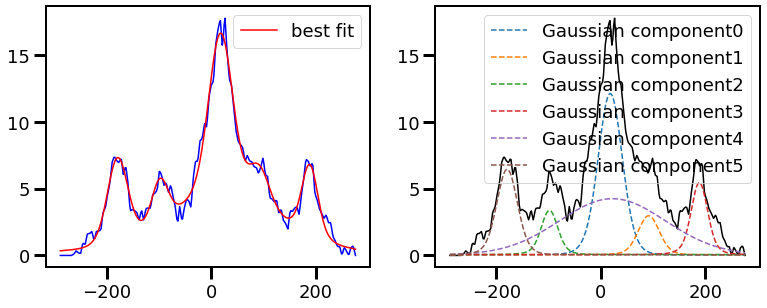

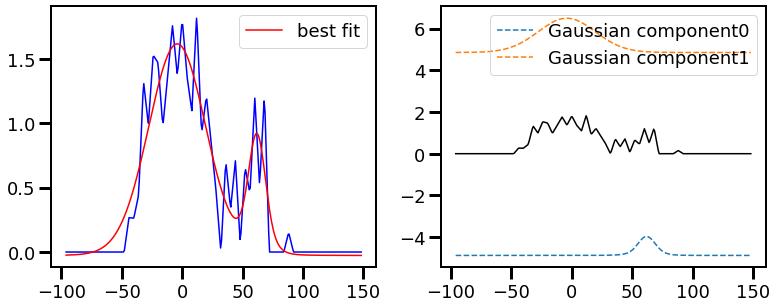

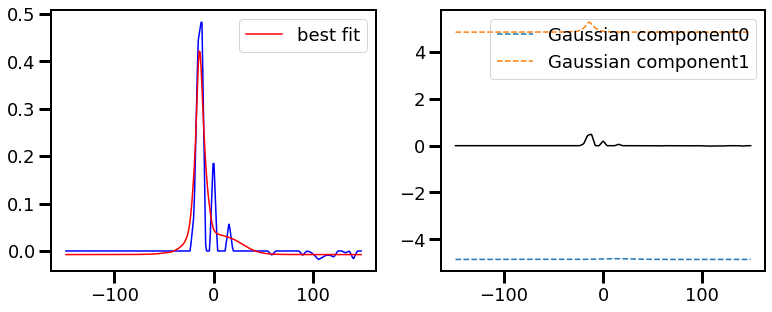

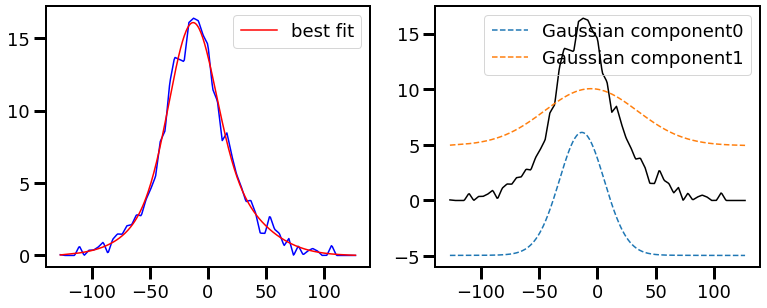

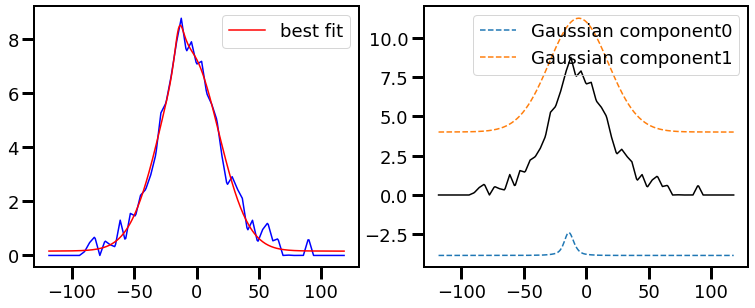

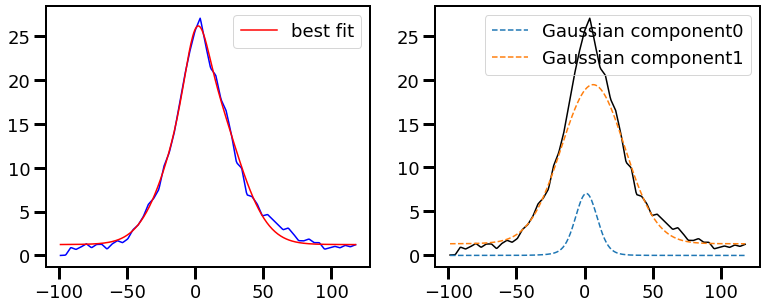

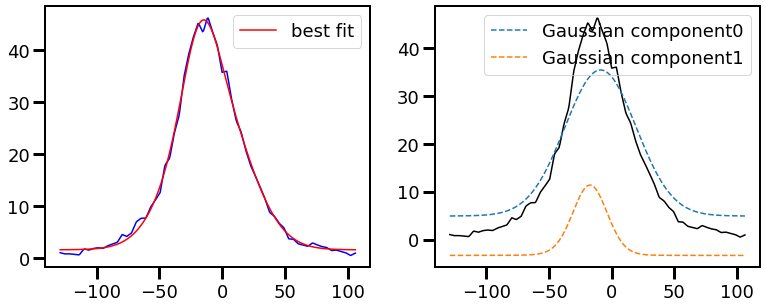

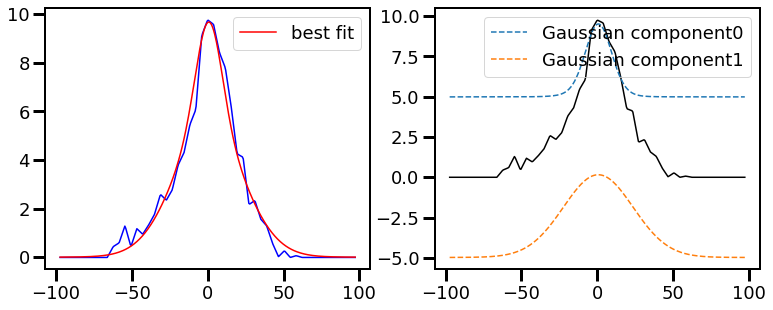

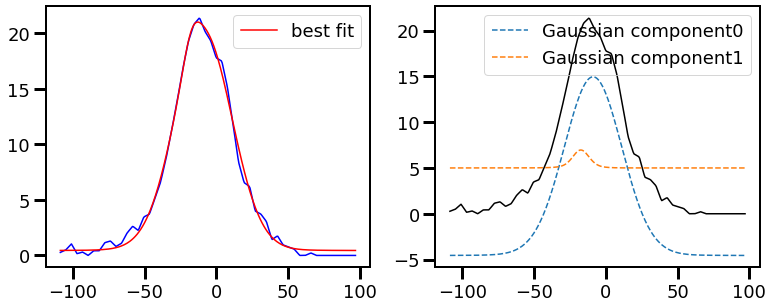

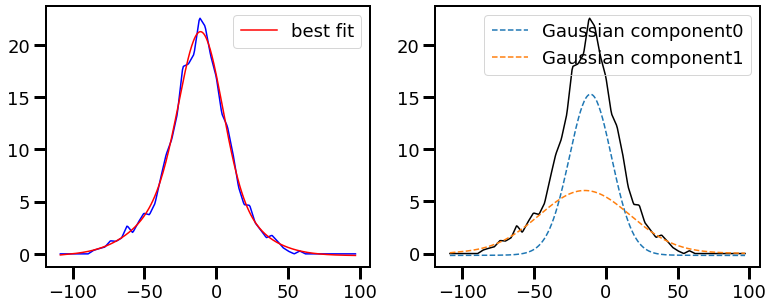

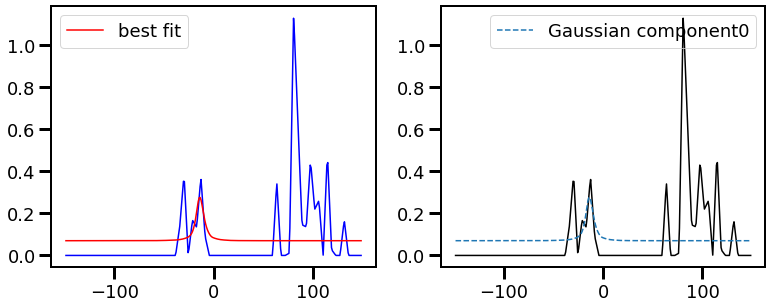

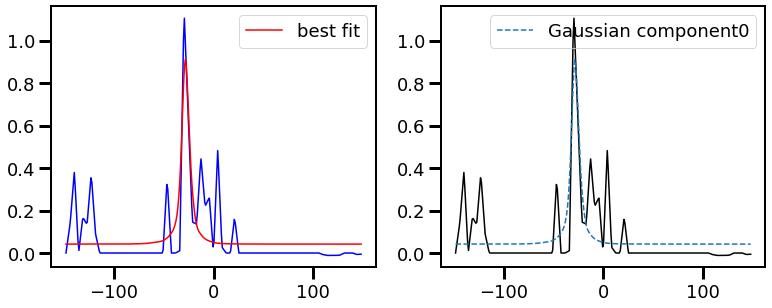

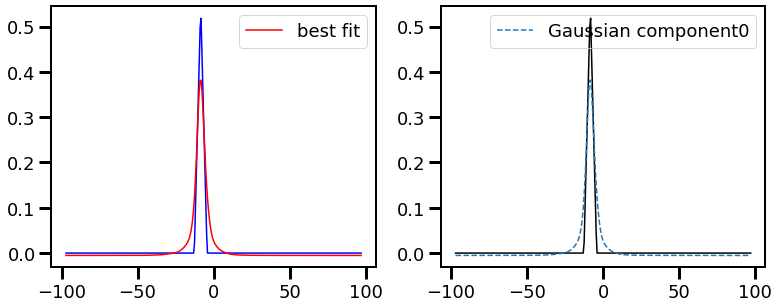

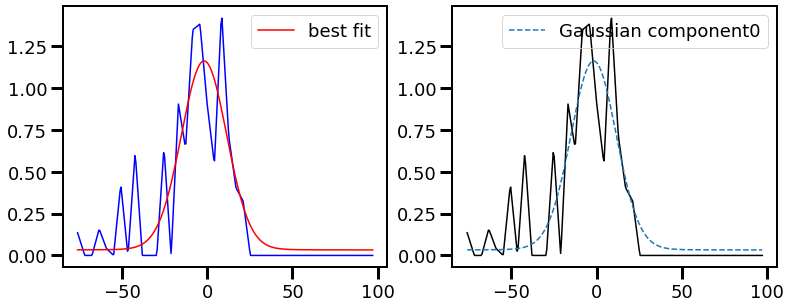

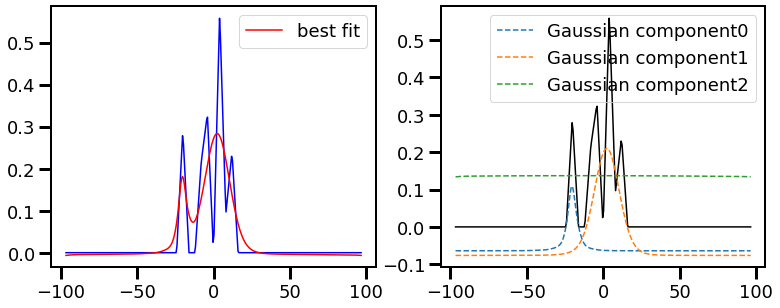

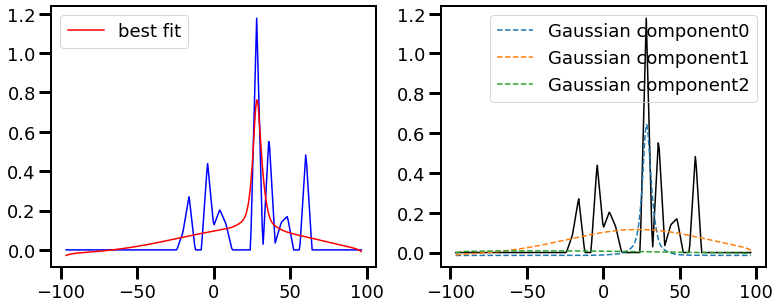

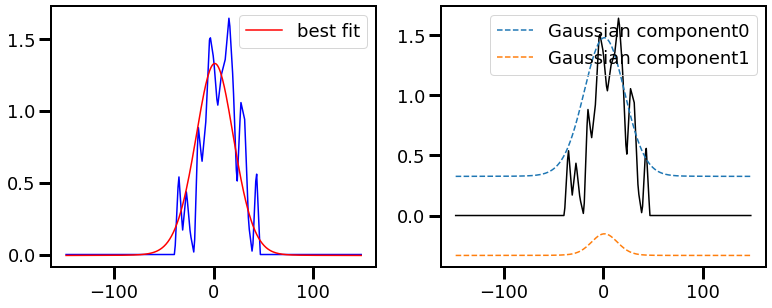

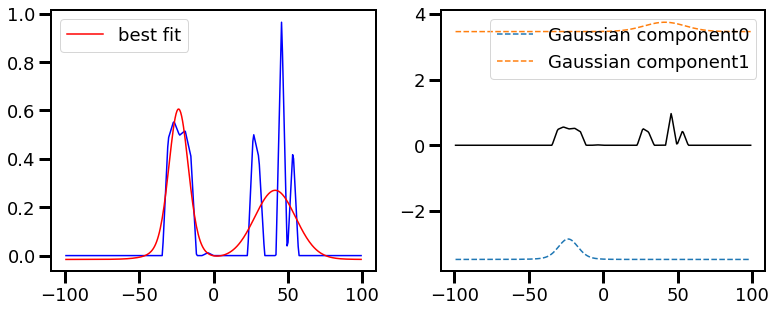

In [28]:
oot = (fwc.orbit == 2) & (fwc.time.value<tpeak-200)
it = np.where((fwc.orbit==2) & (fwc.time.value > tpeak-100))[0]

oof_values = []

for i in range(len(fwc.line_table)):
    if i == 1:
        ngauss = fwc.line_table['ngauss'][i] -1
    else:
        ngauss = fwc.line_table['ngauss'][i]
    args = fwc.model_line_shape(ion=fwc.line_table['ion'][i], 
                                mask=oot, 
                                ngauss=ngauss, 
                                ext=50)
    oof_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(args[0], args[1], 'b')
    #axes[0].plot(vel, init, 'k--', label='initial fit')
    axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')

    comps = args[-1].eval_components(x=args[0])
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

In [85]:
fwc.line_table

ion,wave_c,vmin,vmax,ngauss
str7,float64,int64,int64,int64
CIII,1175.59,-240,230,6
SiII,1264.738,-50,100,3
SiIII,1294.548,-100,100,2
NV_1,1238.831,-80,80,2
NV_2,1242.804,-70,70,2
CII_10,1334.532,-50,70,2
CII_11,1335.708,-80,60,2
OI,1302.1689,-50,50,2
OI_10,1304.858,-60,50,2


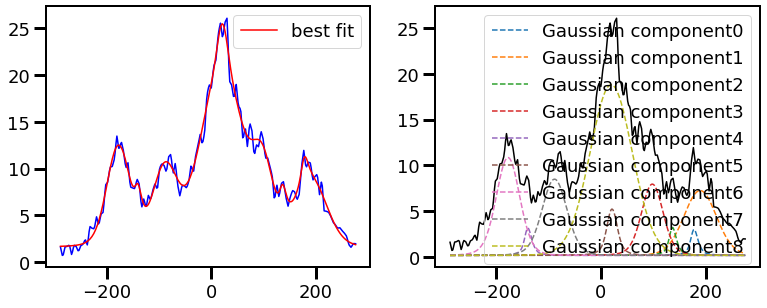

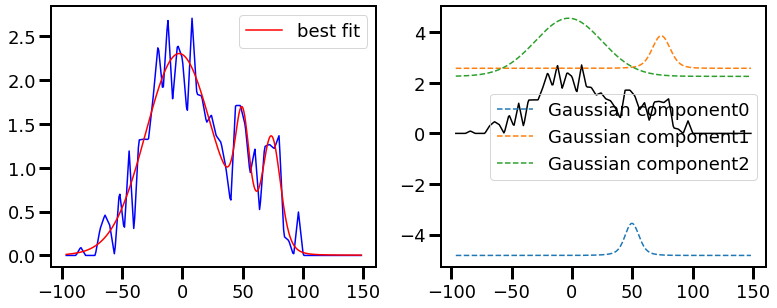

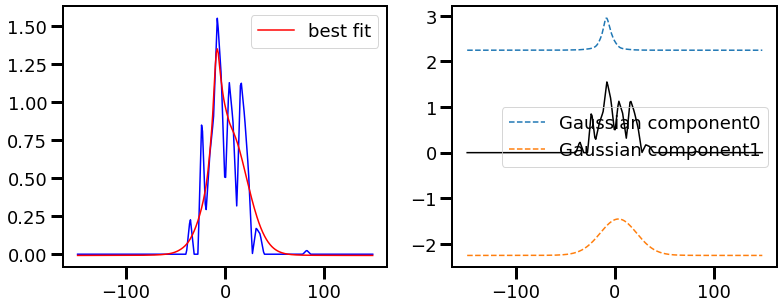

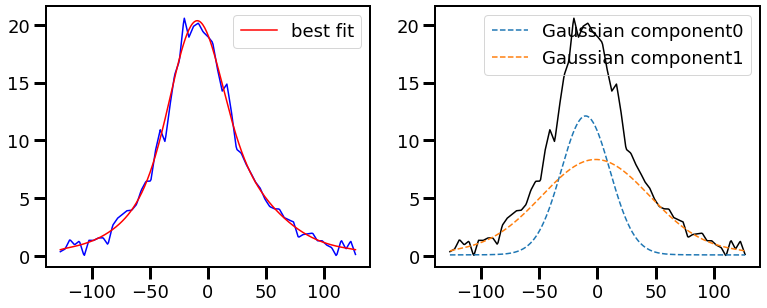

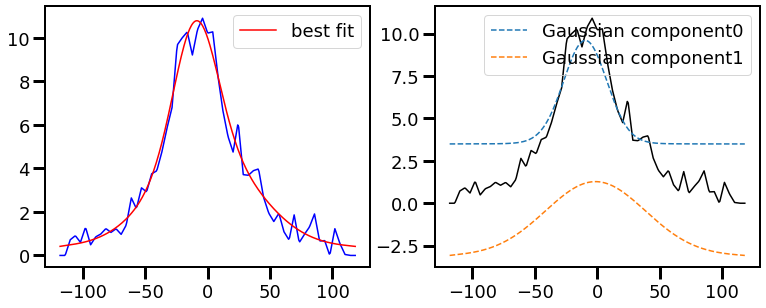

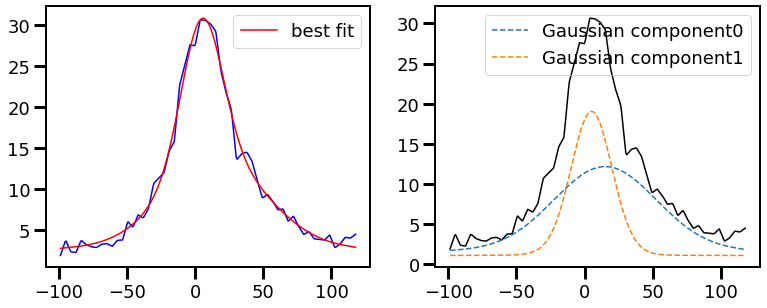

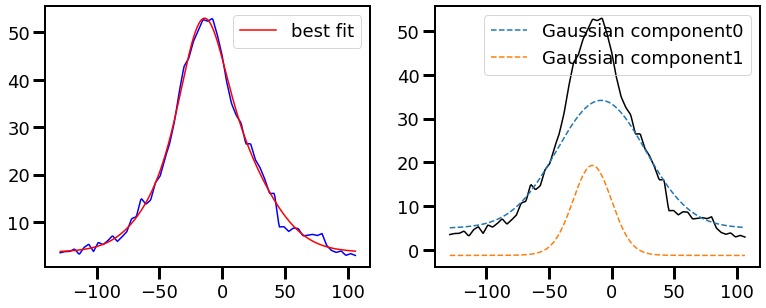

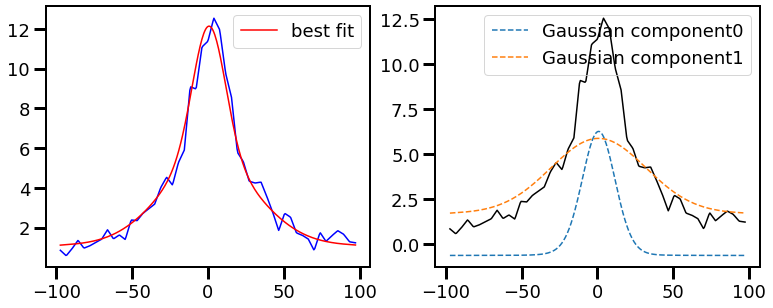

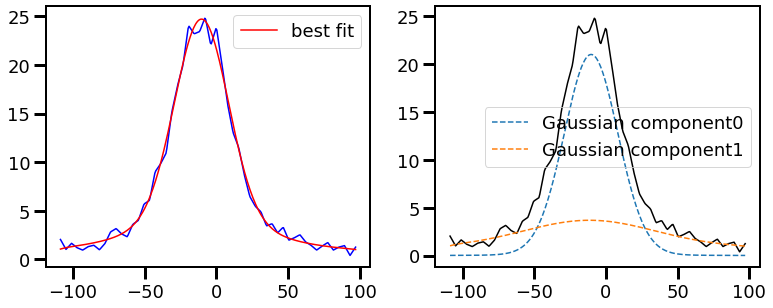

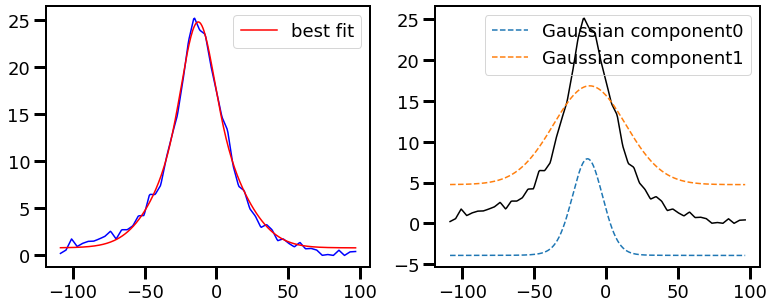

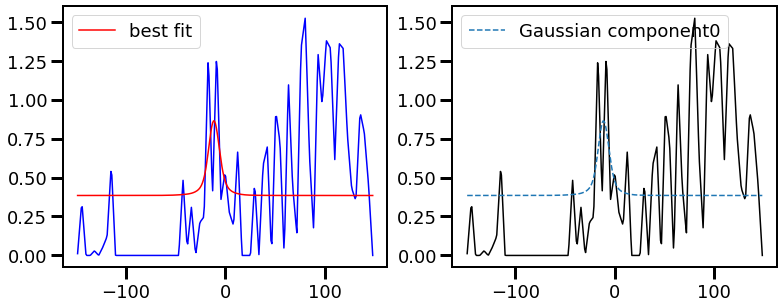

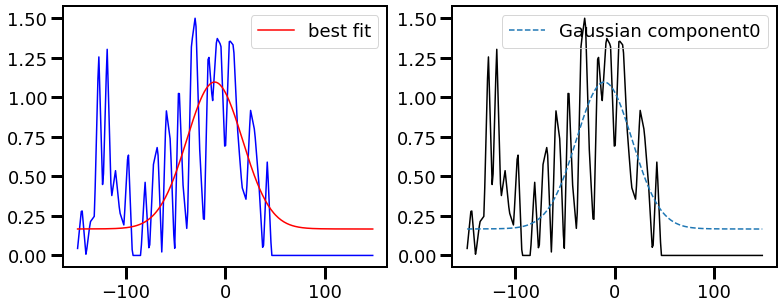

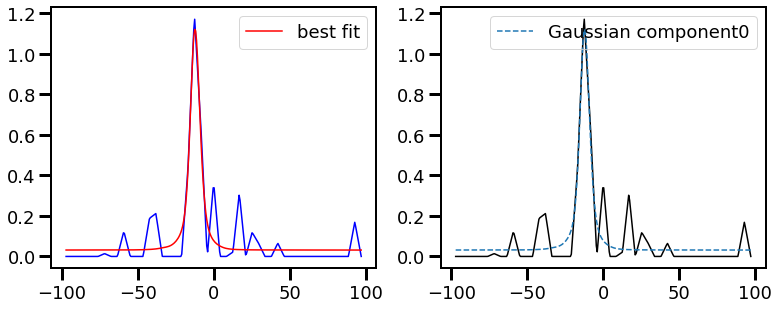

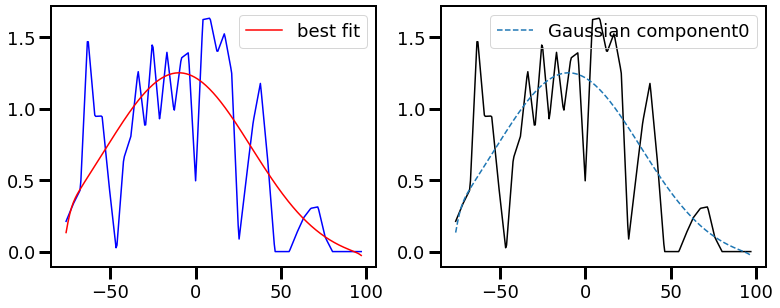

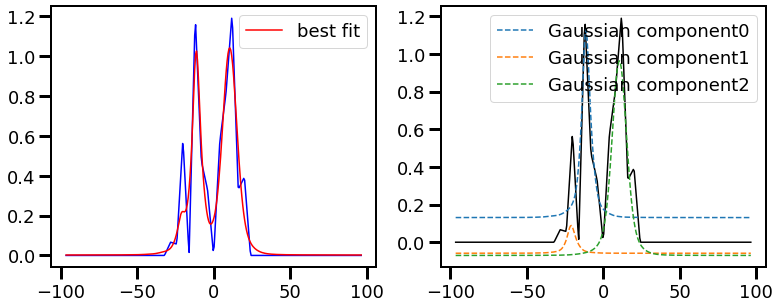

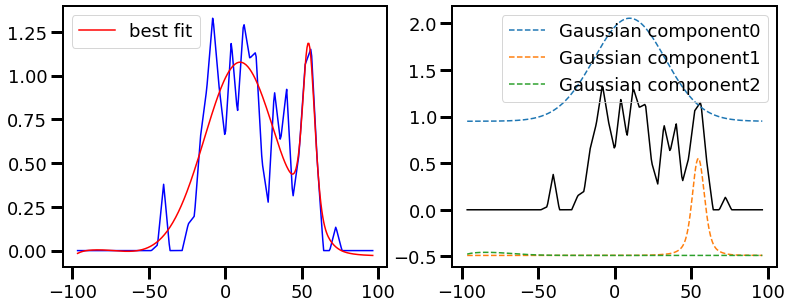

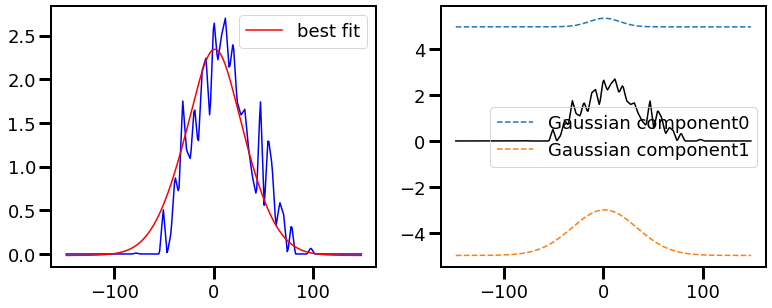

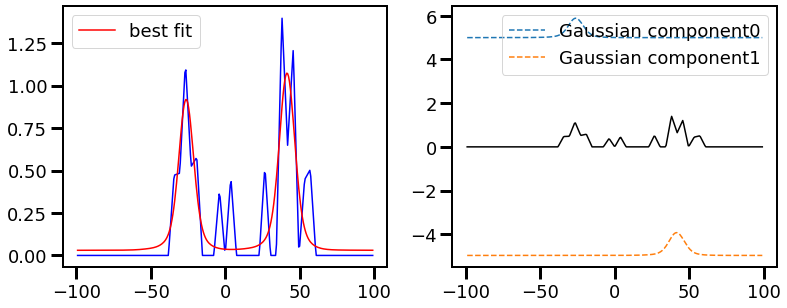

In [29]:
ngauss=4

oot = (fwc.orbit == 2) & (fwc.time.value<tpeak-200)
it = np.where((fwc.orbit==2) & (fwc.time.value > tpeak-100))[0]

if_values = []

for i in range(len(fwc.line_table)):
    if i == 0:
        ngauss = fwc.line_table['ngauss'][i]+3
    else:
        ngauss = fwc.line_table['ngauss'][i]+0
        
    args = fwc.model_line_shape(ion=fwc.line_table['ion'][i], 
                                mask=it, 
                                ngauss=ngauss,
                                ext=50)
    if_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(args[0], args[1], 'b')
    #axes[0].plot(vel, init, 'k--', label='initial fit')
    axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')

    comps = args[-1].eval_components(x=args[0])
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


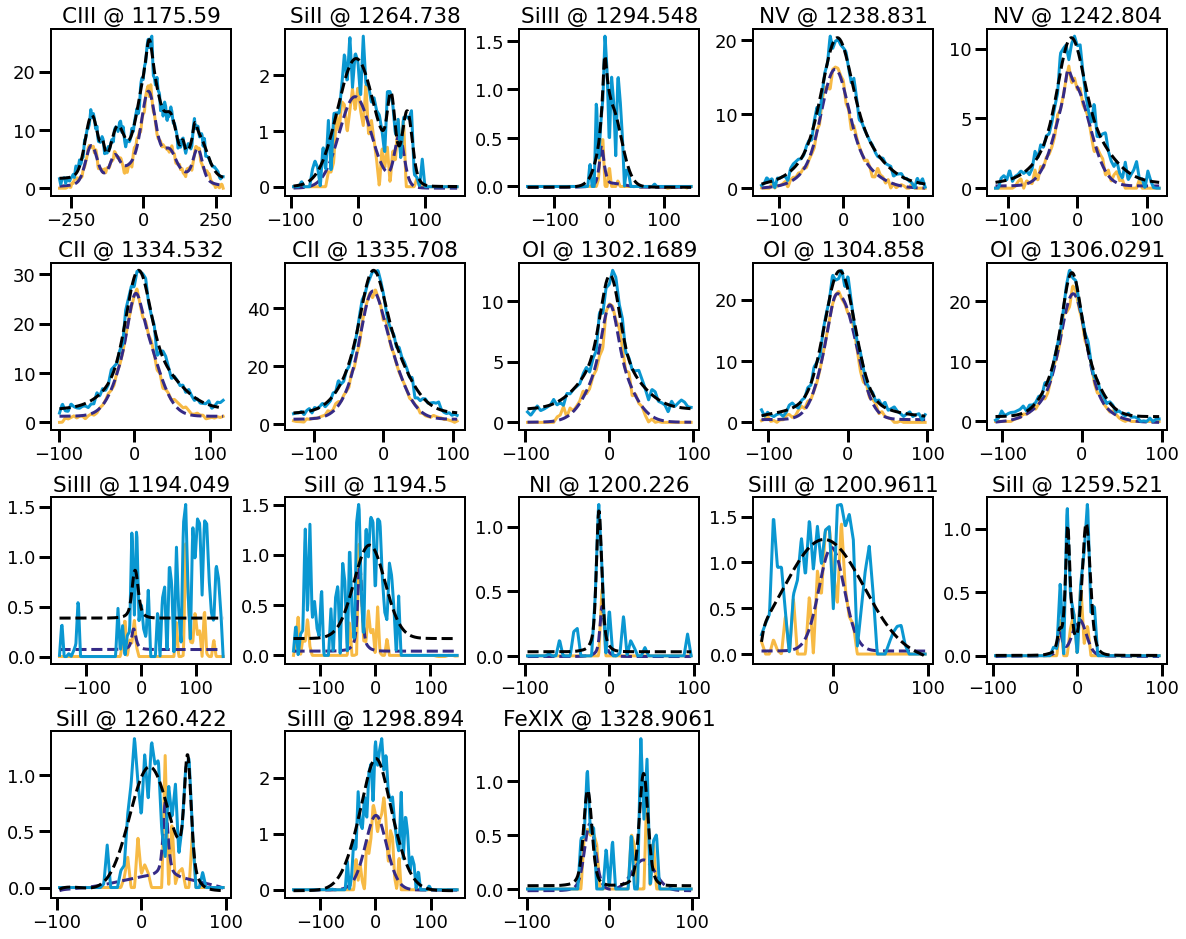

In [34]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20,16))
fig.set_facecolor('w')
lw = 3
i = 0

for ax in axes.reshape(-1):
    try:
        ax.plot(oof_values[i][0], oof_values[i][1], parula[210], lw=lw)

        e = np.trapz(oof_values[i][-1].best_fit*fwc.flux_units,
                     x=oof_values[i][0]*units.km/units.s)*4*np.pi*distance**2

        ax.plot(oof_values[i][0], oof_values[i][-1].best_fit, '--', c=parula[0], lw=lw)

        ax.plot(if_values[i][0], if_values[i][1], parula[80], lw=lw)
        ax.plot(if_values[i][0], if_values[i][-1].best_fit, 'k--', lw=lw)

        ax.set_title('{} @ {}'.format(fwc.line_table['ion'][i].split('_')[0], 
                                      fwc.line_table['wave_c'][i]))
    except IndexError:
        ax.axis('off')
    
    
    i += 1
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/lineprofiles.png', 
           rasterize=True, bbox_inches='tight', dpi=250)

## comparing line widths

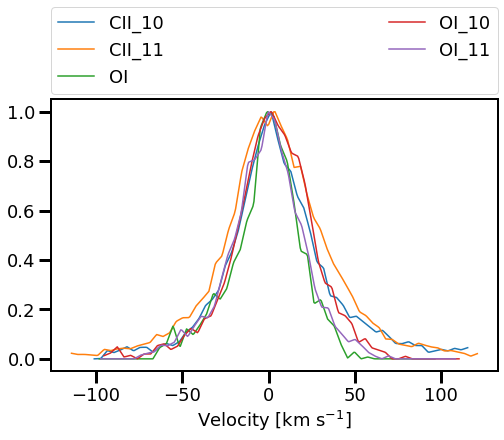

In [54]:
fig = plt.figure(figsize=(8,5))

for i in range(5,10):
    
    v_shift = np.argmax(oof_values[i][-1].best_fit)
    
    plt.plot(oof_values[i][0]-oof_values[i][0][v_shift], 
             oof_values[i][1]/np.nanmax(oof_values[i][1]),
             #if_values[i][-1].best_fit/np.nanmax(if_values[i][-1].best_fit), 
             label=fwc.line_table['ion'][i])
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Velocity [km s$^{-1}$]');

In [72]:
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion=ion)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


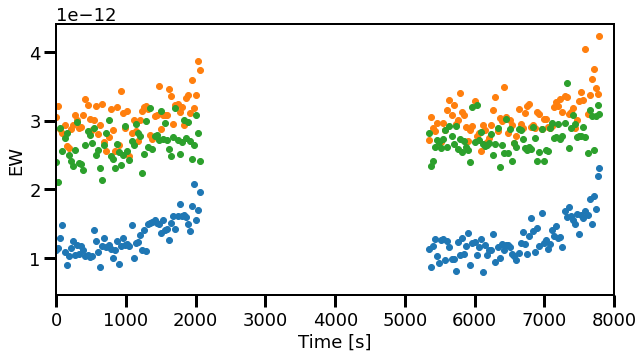

In [84]:
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('w')
plt.plot(fwc.time, fwc.width_table['OI'],'o')
plt.plot(fwc.time, fwc.width_table['OI_10'],'o')
plt.plot(fwc.time, fwc.width_table['OI_11'],'o')
plt.xlim(0,8000)
plt.xlabel('Time [s]')
plt.ylabel('EW')
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/oxygen_airglow.png', dpi=200,
            rasterize=True, bbox_inches='tight')

In [ ]:
fwc.identify_continuum()

In [ ]:
q = template > 0
qc= template[fwc.continuum_mask[0]==0] > 0

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8),
                               sharex=True, sharey=True)
fig.set_facecolor('w')

ax1.plot(fwc.wavelength[0][q], template[q]/1e-13, 'k', 
         label='Spectrum', lw=lw)
ax1.plot(fwc.wavelength[0][fwc.continuum_mask[0]==0][qc], 
         template[fwc.continuum_mask[0]==0][qc]/1e-13, parula[80],
         label='Continuum', lw=lw)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

e =(np.trapz(template[fwc.continuum_mask[0]==0]*fwc.flux_units, 
          x=fwc.wavelength[0][fwc.continuum_mask[0]==0]*units.AA)*4*np.pi*distance**2).to(units.erg/units.s)
ax1.text(s='continuum = ' + str(np.round(e.value/1e27,2))+' x 10$^{27}$ erg s$^{-1}$', 
         x=1060, y=3)

q = max_template > 0
qc= max_template[fwc.continuum_mask[0]==0] > 0

ax2.plot(fwc.wavelength[0][q], max_template[q]/1e-13, 'k', lw=lw)
ax2.plot(fwc.wavelength[0][fwc.continuum_mask[0]==0][qc], 
         max_template[fwc.continuum_mask[0]==0][qc]/1e-13, 
         parula[80], lw=lw)
e = (np.trapz(max_template[fwc.continuum_mask[0]==0]*fwc.flux_units, 
          x=fwc.wavelength[0][fwc.continuum_mask[0]==0]*units.AA)*4*np.pi*distance**2).to(units.erg/units.s)
ax2.text(s='continuum = ' + str(np.round(e.value/1e28,2))+' x 10$^{28}$ erg s$^{-1}$', 
         x=1060, y=10**-5)

ax2.set_ylabel('Flux [$10^{-13}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', y=1.2)
ax2.set_xlabel('Wavelength [$\AA$]')
plt.yscale('log')
plt.savefig('/Users/arcticfox/Documents/AUMic/figures/continuum.png', rasterize=True,
            bbox_inches='tight', dpi=250)